In [2]:
!pip install livelossplot

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from livelossplot import PlotLossesKeras

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid

def get_img_activations(model, input_img, num_conv_layers):
  layer_outputs = [layer.output for layer in model.layers[:num_conv_layers]]
  activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
  activations = activation_model.predict(input_img)
  return activations

def plot_layer(name, activation):
  print(f"Output of {name}")
  how_many_features_map = activation.shape[3]
  figure_size = how_many_features_map * 2
  fig = plt.figure(figsize=(figure_size, figure_size),)
  grid = ImageGrid(fig, 111,
                    nrows_ncols=(how_many_features_map // 16, 16),
                    axes_pad=0.1,  # pad between axes in inch.
                    )
  images = [activation[0, :, :, i] for i in range(how_many_features_map)]
  for ax, img in zip(grid, images):
      ax.matshow(img)
  plt.show()
  return

def plot_model_outputs(model, input_img, num_conv_layers):
  conv_indixes = []
  activations = get_img_activations(model, input_img, num_conv_layers)
  for i in range(len(activations)):
      if( "conv2d" in model.layers[i].name) :
          conv_indixes.append(i)
          print("Layer: ", model.layers[i].name, " Shape: ", activations[i].shape)
  for i, conv_ix in enumerate(conv_indixes):
      plot_layer(model.layers[conv_ix].name, activations[conv_ix])
  return


In [5]:
#Used to create latex tables
extract_regularizer = lambda layer: str(type(layer.kernel_regularizer)).split(".")[-1][:-2]
def get_regularizer_and_value(layer):
  regularizer_name = extract_regularizer(layer) if hasattr(layer, "kernel_regularizer") and extract_regularizer(layer) in ["L1", "L2"] else None
  if regularizer_name:
    isL1 = regularizer_name == "L1"
    value = layer.kernel_regularizer.l1 if isL1 else layer.kernel_regularizer.l2
    regularizer_name = regularizer_name + "=" + str(value)
  return regularizer_name

def get_padding(layer):
  value = "--"
  if type(layer) == tf.keras.layers.Conv2D:
    value = layer.padding
  return value
def table_summary_model(model):
  table=pd.DataFrame(columns=["Name","Type","Shape", "# Params", "Activation", "Regularizer", "Padding"])
  for layer in model.layers:
    activation_fn_name = layer.activation.__name__ if hasattr(layer, "activation") else None
    regularizer_name = get_regularizer_and_value(layer)
    padding = get_padding(layer)
    table = table.append({"Name":layer.name, "Type": layer.__class__.__name__,"Shape":layer.output_shape, "Activation": activation_fn_name, "# Params": layer.count_params(), "Regularizer": regularizer_name, "Padding": padding}, ignore_index=True)
  return table

def latex_table_summary(model):
  table = table_summary_model(model)
  print(table.to_latex(index=False))
  return

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


Text(0.5, 1.0, 'Truck (9)')

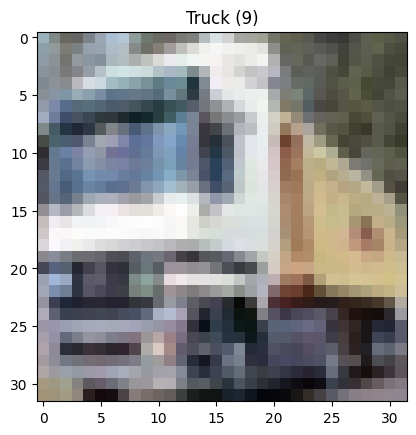

In [ ]:
idx = 1
plt.imshow(X_train[idx])
plt.title("Truck (9)")

In [ ]:
X_train = X_train / 255.
X_test = X_test / 255.
X_train.dtype

dtype('float64')

In [ ]:
print(y_test[1])
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
print(y_test[1])

[8]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, MaxPool2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2

#BaseLine

In [ ]:
#BaseLine
baseline_model = Sequential([
    Conv2D(16,5,padding="same",input_shape=X_train[0].shape, activation="relu"),
    MaxPooling2D(),
    Conv2D(32,5,activation="relu"),
    MaxPooling2D(),
    #Conv2D(64, 3, activation="relu"),
    #MaxPooling2D(),
    Flatten(),
    Dense(10, activation="softmax")
])

baseline_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 10)                1

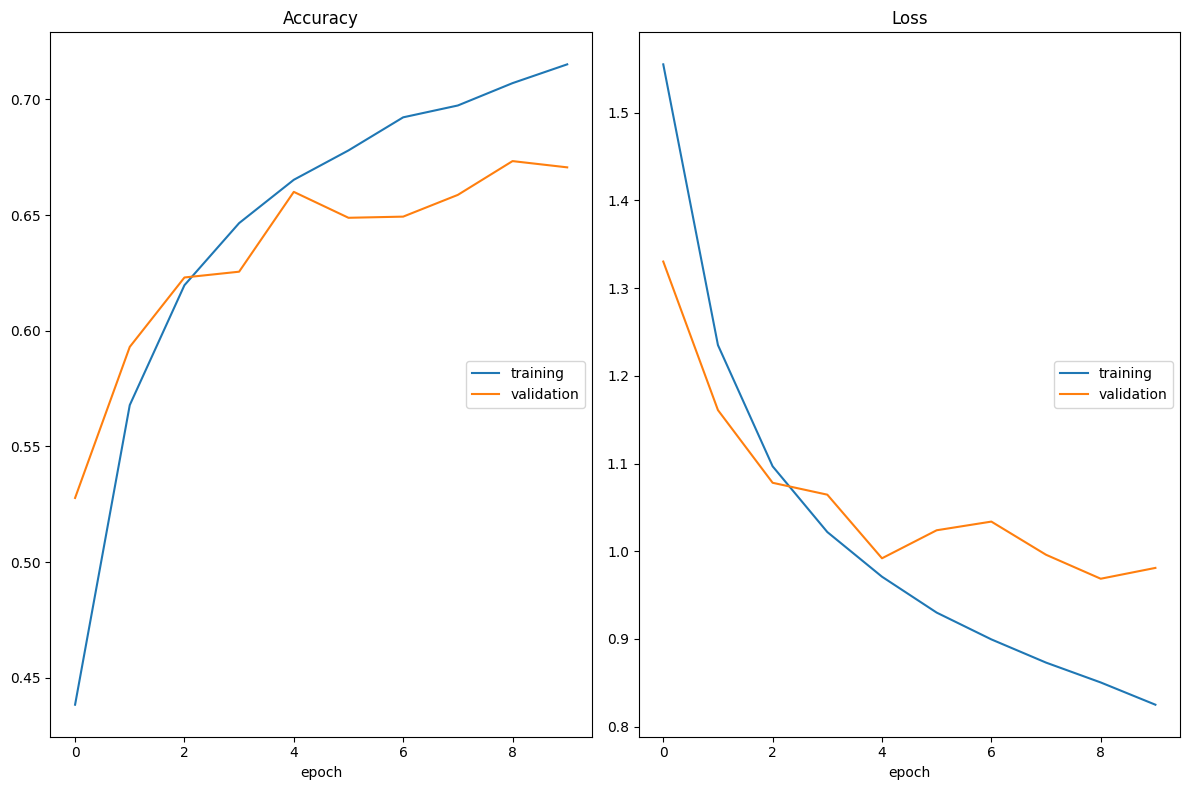

Accuracy
	training         	 (min:    0.438, max:    0.715, cur:    0.715)
	validation       	 (min:    0.528, max:    0.673, cur:    0.671)
Loss
	training         	 (min:    0.825, max:    1.555, cur:    0.825)
	validation       	 (min:    0.969, max:    1.330, cur:    0.981)


In [ ]:
epochs = 10
batch_size = 32
callbacks = [PlotLossesKeras()]

baseline_history = baseline_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0
)

In [ ]:
y_pred = baseline_model.predict(X_test).argmax(axis=1)
b_cm, b_cr = confusion_matrix(y_pred, y_test.argmax(axis=1)), classification_report(y_pred, y_test.argmax(axis=1))

313/313 [==============================] - 1s 3ms/step


In [ ]:
labels = "airplane automobile bird cat deer dog frog horse ship truck".split()

In [ ]:
print(b_cr)

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1051
           1       0.78      0.82      0.80       952
           2       0.46      0.65      0.54       715
           3       0.50      0.47      0.48      1068
           4       0.63      0.57      0.60      1104
           5       0.59      0.54      0.56      1094
           6       0.73      0.72      0.73      1013
           7       0.73      0.72      0.73      1008
           8       0.81      0.77      0.79      1045
           9       0.73      0.77      0.75       950

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



Baseline model sa po 3 epochach pretrenuje a vo vysledku dosahuje maximalnu acc na validacnomd atasete 70,6%

#Model

In [ ]:
def create_model():
  model = Sequential([
    Conv2D(32, 5, padding="same", input_shape=X_train[0].shape, activation="relu"),
    MaxPooling2D(),
    Conv2D(64, 5, activation="relu"),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(128, 5, activation="relu"),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation="relu", kernel_regularizer=L2()),
    Dense(10, activation="softmax")
  ])
  model.compile(
      loss="categorical_crossentropy",
      optimizer=Adam(),
      metrics=["acc"]
  )
  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 64)        51264     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 conv2d_10 (Conv2D)          (None, 2, 2, 128)        

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

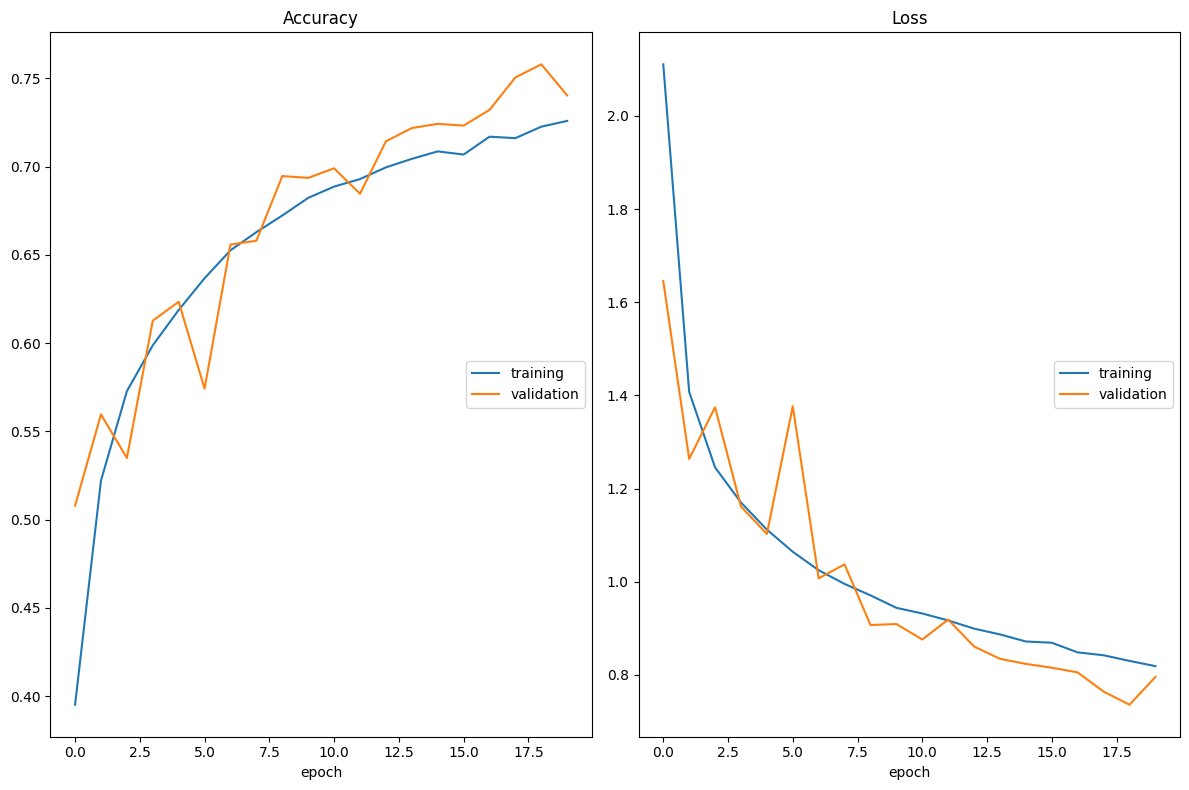

Accuracy
	training         	 (min:    0.395, max:    0.726, cur:    0.726)
	validation       	 (min:    0.508, max:    0.758, cur:    0.740)
Loss
	training         	 (min:    0.819, max:    2.111, cur:    0.819)
	validation       	 (min:    0.736, max:    1.646, cur:    0.795)


In [ ]:
model = create_model()
epochs = 20
batch_size = 128
callbacks = [
    PlotLossesKeras(),
    ReduceLROnPlateau(patience=3),
    EarlyStopping(patience=5),
    ModelCheckpoint("bestModel.h5", save_best_only=True)
]

model_history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0
) #TOTO

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1))

313/313 [==============================] - 1s 3ms/step


0.7403

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomFlip, RandomTranslation, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [ ]:
def augment_model():
  model = create_model()
  inputs = Input(shape=X_train[0].shape)
  x = Rescaling(1./255)(inputs)
  x = RandomRotation(factor=0.2)(x)
  x = RandomZoom(height_factor=0.2, width_factor=0.2)(x)
  x = RandomFlip(mode="horizontal")(x)
  output = model(x)
  model = Model(inputs, output)
  model.compile(
      loss="categorical_crossentropy",
      optimizer=Adam(),
      metrics=["acc"]
  )
  return model

In [ ]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
accuracy_scores = []
hs = []
epochs = 20
batch_size = 128
callbacks = [
    ReduceLROnPlateau(patience=5),
]
fn = 0
for train_index, val_index in skf.split(X_train, y_train.argmax(axis=1)):
    fn += 1
    m = augment_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    h_m = m.fit(
      X_train_fold,
      y_train_fold,
      validation_data=(X_val_fold, y_val_fold),
      epochs=epochs,
      batch_size=batch_size,
      callbacks=callbacks,
      verbose=0
    )

    accuracy = accuracy_score(y_val_fold.argmax(axis=1), m.predict(X_val_fold).argmax(axis=1))
    print("Fold ", fn, " acc: ", accuracy)
    accuracy_scores.append(accuracy)
    hs.append(h_m)

313/313 [==============================] - 8s 24ms/step
Fold  1  acc:  0.4614


In [ ]:
def collect_data(hs):
  output_data = dict()
  recorded_data_types = list(hs[0].history.keys())
  data_df = pd.DataFrame([h.history for h in hs])
  output_data = dict()
  for data_type in recorded_data_types:
    fold_info_array = []
    for fold_info in data_df[data_type]:
      fold_info_array.append(fold_info)
    output_data[data_type] = np.array(fold_info_array).mean(axis=0)
  return output_data

In [ ]:
def plot_acc_ls(avg_loss_t, avg_acc_t, avg_loss_v, avg_acc_v, lr):
  plt.figure(figsize=(6, 10))

  # Loss Plot
  plt.subplot(2, 1, 1)
  plt.plot(avg_loss_t, label='Average Training Loss')
  plt.plot(avg_loss_v, label='Average Validation Loss')
  plt.title('Average Loss Across Folds')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Accuracy Plot
  plt.subplot(2, 1, 2)
  plt.plot(avg_acc_t, label='Average Training Accuracy')
  plt.plot(avg_acc_v, label='Average Validation Accuracy')
  plt.title('Average Accuracy Across Folds')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

  plt.plot(np.log10(lr), label='Average Log-Learning Rate')
  plt.title('Average Log-learning Rate Across Folds')
  plt.xlabel('Epochs')
  plt.ylabel('Log(lr)')
  plt.legend()
  plt.show()

  return

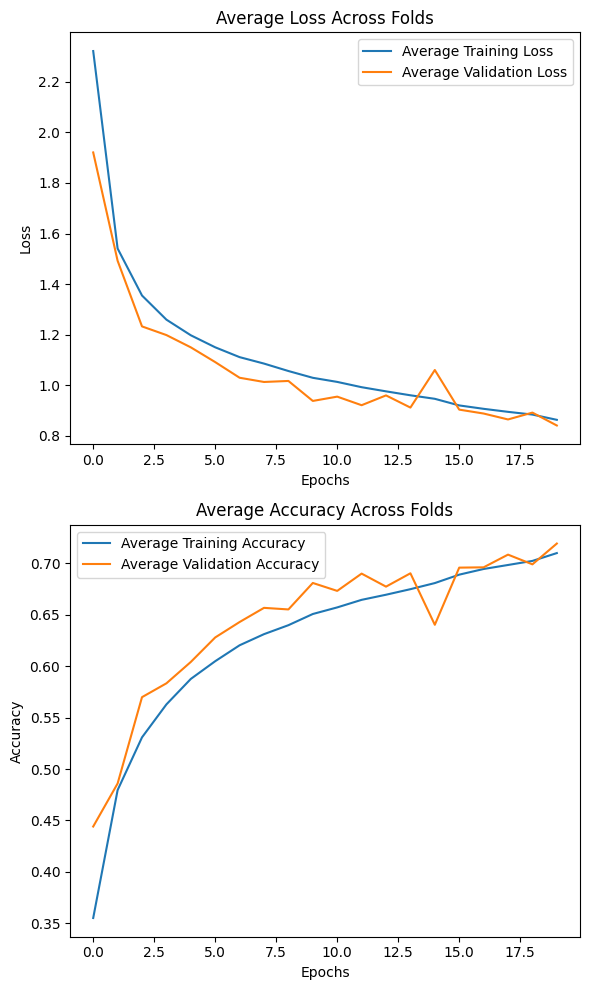

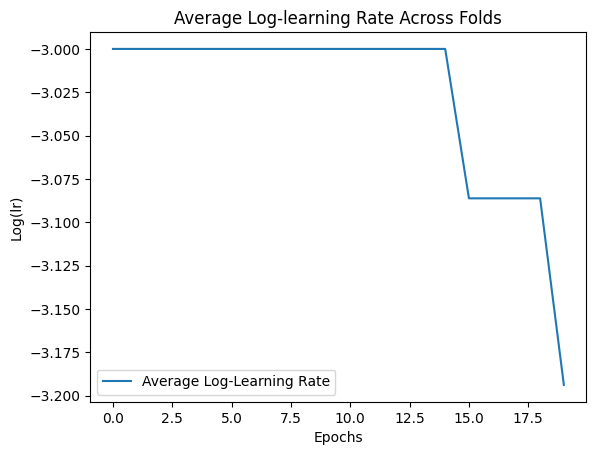

In [ ]:
cd = collect_data(hs)
plot_acc_ls(cd["loss"],cd["acc"],cd["val_loss"],cd["val_acc"], cd["lr"])

In [ ]:
y_pred = m.predict(X_test).argmax(axis=1)
cm, cr = confusion_matrix(y_pred, y_test.argmax(axis=1)), classification_report(y_pred, y_test.argmax(axis=1))
accuracy_score(y_test.argmax(axis=1), y_pred)

313/313 [==============================] - 1s 3ms/step


0.7394